## ML Optimization pt.3 – Hyperparameter Optimization with Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

### Prepare data

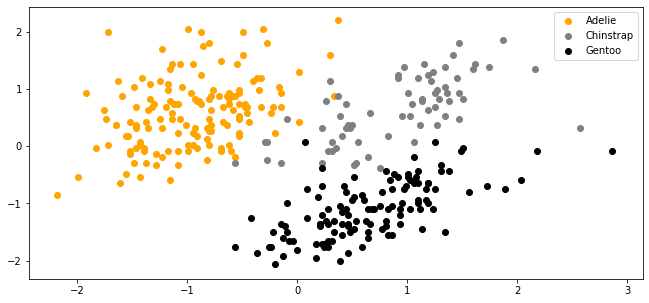

In [2]:
data = pd.read_csv('./data/penguins_size.csv')

data = data.dropna()
data = data.drop(['sex', 'island', 'flipper_length_mm', 'body_mass_g'], axis=1)

X = data.drop(['species'], axis=1)

ss = StandardScaler()
X = ss.fit_transform(X) 

y = data['species']
spicies = {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}
y = [spicies[item] for item in y]
y = np.array(y) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

plt.figure(figsize=(11, 5))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='orange', label='Adelie')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='gray', label='Chinstrap')
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], color='black', label='Gentoo')

plt.legend();

### Grid Search

In [3]:
hyperparameters = {
    'C': [0.1, 1, 100, 500, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.005, 0.1, 1, 3, 5],
    'kernel': ('linear', 'rbf')
}

grid = GridSearchCV(
        estimator=SVC(),
        param_grid=hyperparameters,
        cv=5, 
        scoring='f1_micro', 
        n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 100, 500, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.005, 0.1, 1, 3, 5],
                         'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_micro', verbose=0)

In [4]:
print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Best parameters: {'C': 500, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.9626834381551361


In [5]:
print(f'All results: {grid.cv_results_}')

All results: {'mean_fit_time': array([0.00140033, 0.00259953, 0.00120015, 0.0025991 , 0.00099969,
       0.00260062, 0.00139918, 0.00220079, 0.00099945, 0.0019999 ,
       0.00099978, 0.0026001 , 0.00120473, 0.00179911, 0.00080009,
       0.00360074, 0.00039978, 0.00239973, 0.00139971, 0.00319963,
       0.00040002, 0.00180049, 0.00060015, 0.00499892, 0.00039978,
       0.00100031, 0.00059996, 0.00100055, 0.00039973, 0.00179963,
       0.00039968, 0.00179939, 0.00080013, 0.00100002, 0.00059981,
       0.00079994, 0.0006001 , 0.00039988, 0.00079994, 0.00219965,
       0.00059996, 0.00040002, 0.00080023, 0.00100036, 0.0006011 ,
       0.00180054, 0.00120111, 0.00240002, 0.00140038, 0.00100074,
       0.00139961, 0.00100021, 0.00200067, 0.00079999, 0.00180001,
       0.00119958, 0.00219941, 0.00099945, 0.0011991 , 0.00099945,
       0.00100088, 0.00119839, 0.00140557, 0.00180225, 0.00180025,
       0.0004004 , 0.00399942, 0.0011991 , 0.00460124, 0.00100012,
       0.00219965, 0.00120192, 

In [6]:
model = SVC(C=500, gamma = 0.1, kernel = 'rbf')
model.fit(X_train, y_train)

preditions = model.predict(X_test)
print(f1_score(preditions, y_test, average='micro'))

0.9701492537313433


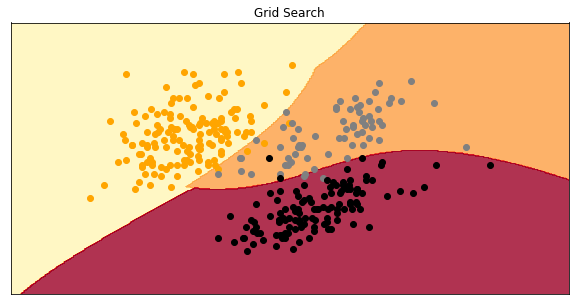

In [7]:
h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plt.figure(figsize=(10, 20))


plt.subplot(3, 1, 1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='YlOrRd', alpha=0.8)

plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='orange', label='Adelie')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='gray', label='Chinstrap')
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], color='black', label='Gentoo')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Grid Search')

plt.show()

### Random Search

In [8]:
hyperparameters = {
    "C": stats.uniform(500, 1500),
    "gamma": stats.uniform(0, 1),
    'kernel': ('linear', 'rbf')
}

random = RandomizedSearchCV(
                estimator = SVC(), 
                param_distributions = hyperparameters, 
                n_iter = 100, 
                cv = 3, 
                random_state=42, 
                n_jobs = -1)

random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021ACF0A03C8>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021ACF0C20C8>,
                                        'kernel': ('linear', 'rbf')},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [9]:
print(f'Best parameters: {random.best_params_}')
print(f'Best score: {random.best_score_}')

Best parameters: {'C': 510.5994578295761, 'gamma': 0.023062425041415757, 'kernel': 'linear'}
Best score: 0.9700374531835205


In [10]:
print(f'All results: {random.cv_results_}')

All results: {'mean_fit_time': array([0.0016667 , 0.00133268, 0.00066145, 0.00166694, 0.00066694,
       0.00033323, 0.00100088, 0.00166663, 0.00100001, 0.00132823,
       0.00266671, 0.00266711, 0.00233269, 0.00066678, 0.00199954,
       0.00066741, 0.0013334 , 0.0006667 , 0.00133173, 0.00100017,
       0.00133332, 0.0016671 , 0.00266536, 0.00400082, 0.00166615,
       0.00133387, 0.00166639, 0.00133284, 0.00100128, 0.00100032,
       0.00166631, 0.00066733, 0.00033323, 0.00066717, 0.00066654,
       0.00133284, 0.00133403, 0.001333  , 0.00166631, 0.00100032,
       0.00066678, 0.00199858, 0.00200049, 0.00133292, 0.0006667 ,
       0.00233261, 0.00066733, 0.00100025, 0.00233253, 0.00266671,
       0.00200033, 0.00166663, 0.00133212, 0.00166663, 0.00200073,
       0.00100025, 0.00466696, 0.00099905, 0.00099993, 0.00099985,
       0.00066733, 0.0009985 , 0.00133332, 0.00233261, 0.00133348,
       0.00099913, 0.00099953, 0.00033339, 0.00266727, 0.00299931,
       0.00166694, 0.00566665, 

In [11]:
model = SVC(C=510.5994578295761, gamma = 0.023062425041415757, kernel = 'linear')
model.fit(X_train, y_train)

preditions = model.predict(X_test)
print(f1_score(preditions, y_test, average='micro'))

0.9701492537313433


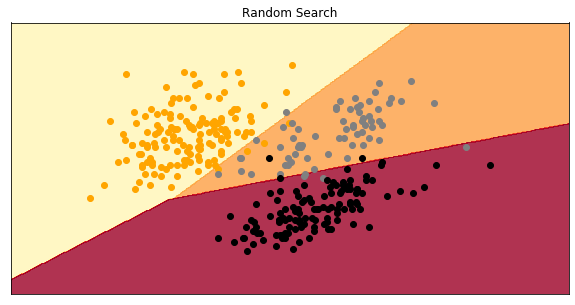

In [12]:
h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plt.figure(figsize=(10, 20))


plt.subplot(3, 1, 1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='YlOrRd', alpha=0.8)

plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='orange', label='Adelie')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='gray', label='Chinstrap')
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], color='black', label='Gentoo')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Random Search')

plt.show()

### Bayesian Optimization

In [13]:
hyperparameters = {
    "C": Real(1e-6, 1e+6, prior='log-uniform'),
    "gamma": Real(1e-6, 1e+1, prior='log-uniform'),
    "kernel": Categorical(['linear', 'rbf']),
}

bayesian = BayesSearchCV(
                estimator = SVC(), 
                search_spaces = hyperparameters, 
                n_iter = 100, 
                cv = 5, 
                random_state=42, 
                n_jobs = -1)

bayesian.fit(X_train, y_train)

G:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
G:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, error_score='raise',
              estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                            class_weight=None, coef0=0.0,
                            decision_function_shape='ovr', degree=3,
                            gamma='scale', kernel='rbf', max_iter=-1,
                            probability=False, random_state=None,
                            shrinking=True, tol=0.001, verbose=False),
              fit_params=None, iid=True, n_iter=100, n_jobs=-1, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=42,
              refit=True, return_train_score=False, scoring=None,
              search_spaces={'C': Real(low=1e-06, high=1000000.0, prior='log-uniform', transform='identity'),
                             'gamma': Real(low=1e-06, high=10.0, prior='log-uniform', transform='identity'),
                             'kernel': Categorical(categories=('linear', 'rbf'), prior=None)},
              verbose

In [14]:
print(f'Best parameters: {bayesian.best_params_}')
print(f'Best score: {bayesian.best_score_}')

Best parameters: OrderedDict([('C', 3932.2516133086), ('gamma', 0.0011646737978730447), ('kernel', 'rbf')])
Best score: 0.9625468164794008


In [15]:
print(f'All results: {bayesian.cv_results_}')

All results: defaultdict(<class 'list'>, {'split0_test_score': [0.9629629629629629, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.46296296296296297, 0.9444444444444444, 0.8703703703703703, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.8703703703703703, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.46296296296296297, 0.8703703703703703, 0.9444444444444444, 0.7962962962962963, 0.46296296296296297, 0.9629629629629629, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.8703703703703703, 0.9444444444444444, 0.46296296296296297, 0.9444444444444444, 0.9629629629629629, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9629629629629629, 0.9444444444

In [20]:
model = SVC(C=3932.2516133086, gamma = 0.0011646737978730447, kernel = 'rbf')
model.fit(X_train, y_train)

preditions = model.predict(X_test)
print(f1_score(preditions, y_test, average='micro'))

0.9850746268656716


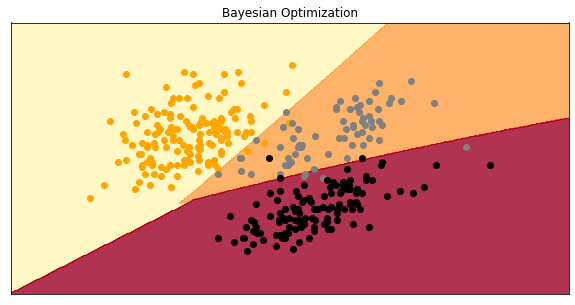

In [21]:
h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plt.figure(figsize=(10, 20))


plt.subplot(3, 1, 1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='YlOrRd', alpha=0.8)

plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='orange', label='Adelie')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='gray', label='Chinstrap')
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], color='black', label='Gentoo')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Bayesian Optimization')

plt.show()